In [2]:
!pip install igraph
!pip install import_ipynb


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import networkx as nx
import networkx.algorithms.community as nxcom
import matplotlib.pyplot as plt
import numpy as np
import time as time
from random import uniform, seed
from igraph import *

In [4]:
import import_ipynb
import Models as models

importing Jupyter notebook from Models.ipynb


In [5]:
import pickle

In [6]:
pb2020 = Graph.Read_GML('PB2020.gml')

https://github.com/hautahi/IM_GreedyCELF 


In [7]:
def IC(g,S,p=0.5,mc=10):
    """
    Input:  graph object, set of seed nodes, propagation probability
            and the number of Monte-Carlo simulations
    Output: average number of nodes influenced by the seed nodes
    """
    
    # Loop over the Monte-Carlo Simulations
    spread = []
    for i in range(mc):
        
        # Simulate propagation process      
        new_active, A = S[:], S[:]
        while new_active:

            # For each newly active node, find its neighbors that become activated
            new_ones = []
            for node in new_active:
                
                # Determine neighbors that become infected
                np.random.seed(i)
                success = np.random.uniform(0,1,len(g.neighbors(node,mode="out"))) < p
                new_ones += list(np.extract(success, g.neighbors(node,mode="out")))

            new_active = list(set(new_ones) - set(A))
            
            # Add newly activated nodes to the set of activated nodes
            A += new_active
            
        spread.append(len(A))
        
    return(np.mean(spread))

In [8]:
def celf(g,k,p=0.1,mc=10):  
    """
    Input:  graph object, number of seed nodes
    Output: optimal seed set, resulting spread, time for each iteration
    """
      
    # Find the first node with greedy algorithm    
    # Calculate the first iteration sorted list
    start_time = time.time() 
    marg_gain = [IC(g,[node],p,mc) for node in range(g.vcount())]

    # Create the sorted list of nodes and their marginal gain 
    Q = sorted(zip(range(g.vcount()),marg_gain), key=lambda x: x[1],reverse=True)

    # Select the first node and remove from candidate list
    S, spread, SPREAD = [Q[0][0]], Q[0][1], [Q[0][1]]
    Q, LOOKUPS, timelapse = Q[1:], [g.vcount()], [time.time()-start_time]
    
    # Find the next k-1 nodes using the list-sorting procedure
    for _ in range(k-1):    

        check, node_lookup = False, 0
        
        while not check:
            
            # Count the number of times the spread is computed
            node_lookup += 1
            
            # Recalculate spread of top node
            current = Q[0][0]
            
            # Evaluate the spread function and store the marginal gain in the list
            Q[0] = (current,IC(g,S+[current],p,mc) - spread)

            # Re-sort the list
            Q = sorted(Q, key = lambda x: x[1], reverse = True)

            # Check if previous top node stayed on top after the sort
            check = (Q[0][0] == current)

        # Select the next node
        spread += Q[0][1]
        S.append(Q[0][0])
        SPREAD.append(spread)
        LOOKUPS.append(node_lookup)
        timelapse.append(time.time() - start_time)

        # Remove the selected node from the list
        Q = Q[1:]

    return(S,SPREAD,timelapse,LOOKUPS)

# Independent Cascade

In [11]:
G = nx.read_gml('PB2020.gml')
G = G.reverse()

In [11]:
Independent_Cascade = models.Independent_Cascade()
Independent_Cascade.fit(G)

p_Independent_Cascade = Independent_Cascade.probability[Independent_Cascade.probability != 0]
celf_output_Independent_Cascade = celf(pb2020, 10, p = np.mean(p_Independent_Cascade), mc = 50)

In [12]:
pickle_Independent_Cascade = pickle.dumps(celf_output_Independent_Cascade)

In [13]:
print("The optimal seed set is: ", celf_output_Independent_Cascade[0])
print("The resulting spread is: ", celf_output_Independent_Cascade[1])
print("The time for each iteration is: ", celf_output_Independent_Cascade[2])
print("The number of times the spread is computed is: ", celf_output_Independent_Cascade[3])

The optimal seed set is:  [1916, 8136, 37, 8051, 7508, 6310, 8068, 7740, 7251, 11887]
The resulting spread is:  [1106.14, 2066.38, 2429.18, 2649.0, 2789.92, 2925.7, 2978.76, 3011.98, 3042.42, 3070.54]
The time for each iteration is:  [311.2968602180481, 314.51875829696655, 334.6221308708191, 1669.59415102005, 1714.9219982624054, 1736.0691168308258, 5018.795011758804, 5982.85812163353, 6010.641767501831, 6015.242363214493]
The number of times the spread is computed is:  [13217, 1, 6, 351, 11, 5, 727, 210, 6, 1]


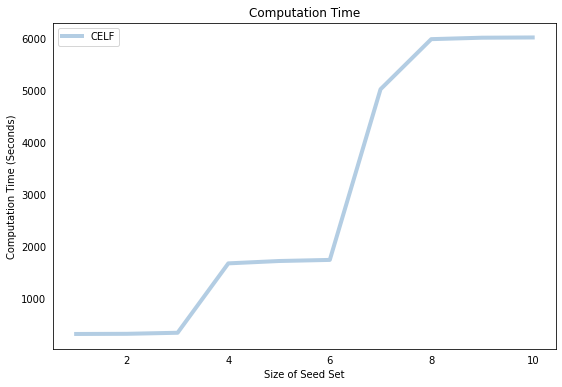

In [33]:
# Plot settings
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

# Plot Computation Time
plt.plot(range(1,len(celf_output_Independent_Cascade[2])+1),celf_output_Independent_Cascade[2],label="CELF",color="#B3CDE3")
plt.ylabel('Computation Time (Seconds)'); plt.xlabel('Size of Seed Set')
plt.title('Computation Time'); plt.legend(loc=2)

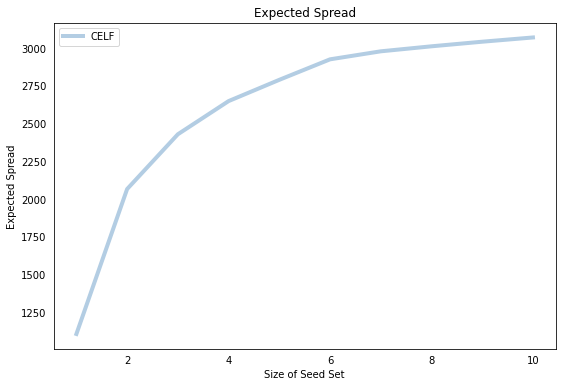

In [15]:
# Plot Expected Spread by Seed Set Size
plt.plot(range(1,len(celf_output_Independent_Cascade[1])+1),celf_output_Independent_Cascade[1],label="CELF",color="#B3CDE3")
plt.xlabel('Size of Seed Set'); plt.ylabel('Expected Spread')
plt.title('Expected Spread'); plt.legend(loc=2)

# Decreasing Cascade

In [16]:
Decreasing_Cascade = models.Decreasing_Cascade()
Decreasing_Cascade.fit(G)

p_Decreasing_Cascade = Decreasing_Cascade.probability[Decreasing_Cascade.probability != 0]
celf_output_Decreasing_Cascade = celf(pb2020, 10, p = np.mean(p_Decreasing_Cascade), mc = 50)

In [17]:
pickle_Decreasing_Cascade = pickle.dumps(celf_output_Independent_Cascade)

In [18]:
print("The optimal seed set is: ", celf_output_Decreasing_Cascade[0])
print("The resulting spread is: ", celf_output_Decreasing_Cascade[1])
print("The time for each iteration is: ", celf_output_Decreasing_Cascade[2])
print("The number of times the spread is computed is: ", celf_output_Decreasing_Cascade[3])

The optimal seed set is:  [1916, 8136, 37, 8051, 7508, 6310, 8068, 7740, 7251, 11887]
The resulting spread is:  [1106.14, 2066.38, 2429.18, 2649.0, 2789.92, 2925.7, 2978.76, 3011.98, 3042.42, 3070.54]
The time for each iteration is:  [312.67027378082275, 316.01764464378357, 337.52797770500183, 1651.6742510795593, 1698.000317811966, 1719.8656072616577, 5004.265845537186, 5980.16846871376, 6008.894874095917, 6013.571175575256]
The number of times the spread is computed is:  [13217, 1, 6, 351, 11, 5, 727, 210, 6, 1]


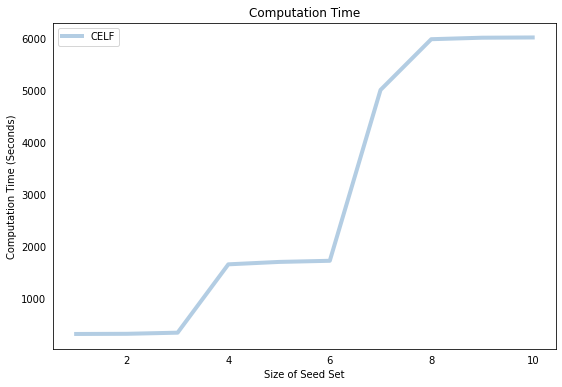

In [19]:
# Plot settings
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

# Plot Computation Time
plt.plot(range(1,len(celf_output_Decreasing_Cascade[2])+1),celf_output_Decreasing_Cascade[2],label="CELF",color="#B3CDE3")
plt.ylabel('Computation Time (Seconds)'); plt.xlabel('Size of Seed Set')
plt.title('Computation Time'); plt.legend(loc=2)

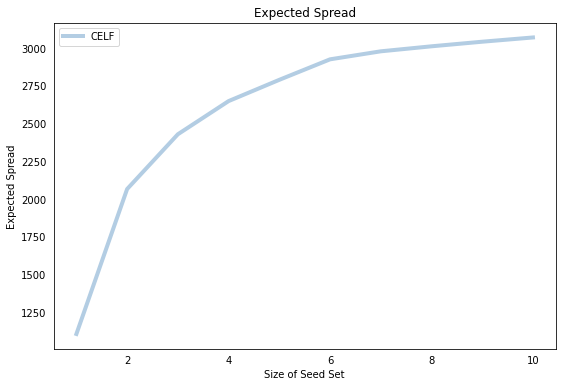

In [20]:
# Plot Expected Spread by Seed Set Size
plt.plot(range(1,len(celf_output_Decreasing_Cascade[1])+1),celf_output_Decreasing_Cascade[1],label="CELF",color="#B3CDE3")
plt.xlabel('Size of Seed Set'); plt.ylabel('Expected Spread')
plt.title('Expected Spread'); plt.legend(loc=2)

# WCM

In [21]:
Weighted_Cascade = models.Weighted_Cascade()
Weighted_Cascade.fit(G)

p_Weighted_Cascade = Weighted_Cascade.probability[Weighted_Cascade.probability != 0]
celf_output_Weighted_Cascade = celf(pb2020, 10, p = np.mean(p_Weighted_Cascade), mc = 50)

In [22]:
pickle_Weighted_Cascade = pickle.dumps(celf_output_Weighted_Cascade)

In [23]:
print("The optimal seed set is: ", celf_output_Weighted_Cascade[0])
print("The resulting spread is: ", celf_output_Weighted_Cascade[1])
print("The time for each iteration is: ", celf_output_Weighted_Cascade[2])
print("The number of times the spread is computed is: ", celf_output_Weighted_Cascade[3])

The optimal seed set is:  [1916, 8136, 37, 8051, 6310, 7508, 8068, 7740, 7251, 1596]
The resulting spread is:  [516.04, 963.96, 1134.22, 1239.48, 1313.38, 1378.48, 1404.46, 1425.0, 1443.64, 1460.26]
The time for each iteration is:  [98.4213969707489, 100.08581185340881, 101.90568351745605, 103.77018451690674, 754.0473434925079, 768.282389163971, 993.2392671108246, 1005.2323846817017, 1013.2168920040131, 1088.7248513698578]
The number of times the spread is computed is:  [13217, 1, 1, 1, 352, 7, 114, 6, 4, 37]


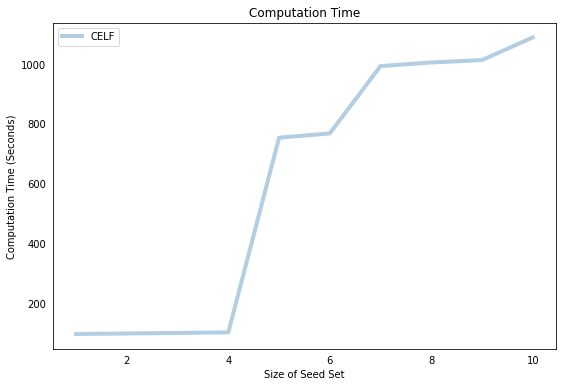

In [24]:
# Plot settings
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

# Plot Computation Time
plt.plot(range(1,len(celf_output_Weighted_Cascade[2])+1),celf_output_Weighted_Cascade[2],label="CELF",color="#B3CDE3")
plt.ylabel('Computation Time (Seconds)'); plt.xlabel('Size of Seed Set')
plt.title('Computation Time'); plt.legend(loc=2)

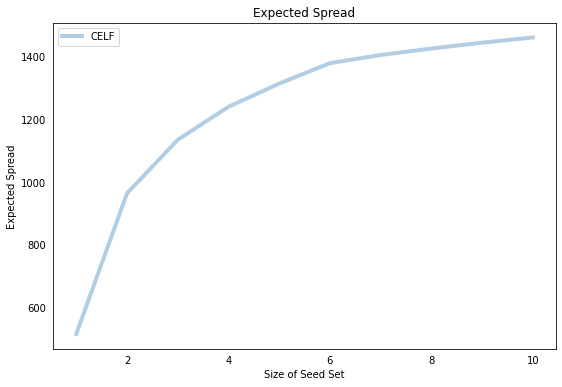

In [25]:
# Plot Expected Spread by Seed Set Size
plt.plot(range(1,len(celf_output_Weighted_Cascade[1])+1),celf_output_Weighted_Cascade[1],label="CELF",color="#B3CDE3")
plt.xlabel('Size of Seed Set'); plt.ylabel('Expected Spread')
plt.title('Expected Spread'); plt.legend(loc=2)

# Trivalency 

In [12]:
Trivalency_Model = models.Trivalency_Model()
Trivalency_Model.fit(G)

p_Trivalency_Model = Trivalency_Model.probability[Trivalency_Model.probability != 0]
celf_output_Trivalency_Model = celf(pb2020, 10, p = np.mean(p_Trivalency_Model), mc = 50)

In [13]:
pickle_Trivalency_Model = pickle.dumps(celf_output_Trivalency_Model)

In [14]:
print("The optimal seed set is: ", celf_output_Trivalency_Model[0])
print("The resulting spread is: ", celf_output_Trivalency_Model[1])
print("The time for each iteration is: ", celf_output_Trivalency_Model[2])
print("The number of times the spread is computed is: ", celf_output_Trivalency_Model[3])

The optimal seed set is:  [1916, 8136, 37, 8051, 6310, 7508, 8068, 7740, 7251, 1596]
The resulting spread is:  [159.6, 298.76, 352.16, 386.2, 411.08, 432.46, 440.56, 448.12, 455.28, 462.06]
The time for each iteration is:  [30.748766899108887, 31.199387788772583, 31.77226686477661, 32.42503643035889, 33.127992391586304, 33.7905752658844, 43.12250471115112, 291.515873670578, 293.71650791168213, 295.93819665908813]
The number of times the spread is computed is:  [13217, 1, 1, 1, 1, 1, 13, 343, 3, 3]


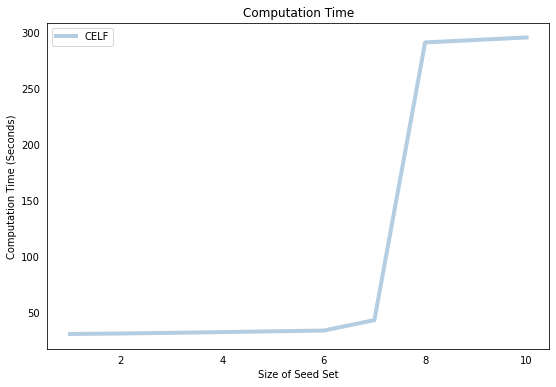

In [15]:
# Plot settings
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

# Plot Computation Time
plt.plot(range(1,len(celf_output_Trivalency_Model[2])+1),celf_output_Trivalency_Model[2],label="CELF",color="#B3CDE3")
plt.ylabel('Computation Time (Seconds)'); plt.xlabel('Size of Seed Set')
plt.title('Computation Time'); plt.legend(loc=2)

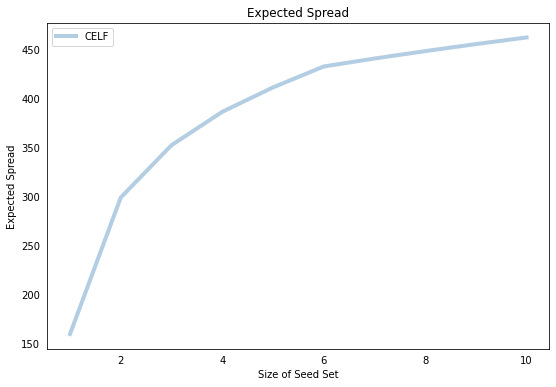

In [16]:
# Plot Expected Spread by Seed Set Size
plt.plot(range(1,len(celf_output_Trivalency_Model[1])+1),celf_output_Trivalency_Model[1],label="CELF",color="#B3CDE3")
plt.xlabel('Size of Seed Set'); plt.ylabel('Expected Spread')
plt.title('Expected Spread'); plt.legend(loc=2)

# Generalized Threshold Mode

# Linear Threshold Mode